In [9]:
import os
import sys
import cv2
import shutil
from model import My_model
import tensorflow as tf 
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,  Lambda
from tensorflow.keras.layers import concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from skimage.io import imread, imshow
from skimage.color import gray2rgb
from skimage.transform import resize
from matplotlib import pyplot as plt
from imgaug import augmenters as iaa

In [2]:
import zipfile
         
fantasy_zip = zipfile.ZipFile('jsons/jsons.zip')
fantasy_zip.extractall('')
 
fantasy_zip.close()

In [1]:
try:
    #Create diractories for training, validating and testing
    os.mkdir('DataSet1/')
    os.makedirs('DataSet1/train')
    os.makedirs('DataSet1/train/images')
    os.makedirs('DataSet1/train/masks')
    os.makedirs('DataSet1/test')
    os.makedirs('DataSet1/test/images')
    os.makedirs('DataSet1/test/masks')
except OSError:
    pass

In [2]:
def find_files(file_path, file_name):
    pf = ""
    for root, dirs, files in os.walk(file_path):
         if file_name in files:
            pf = os.path.join(root, file_name)
            break
    return(pf)

In [5]:
#split data on train and validation
#a SPLIT SIZE to determine the portion
#testing set has 10 images
def split_data(SOURCE_IMAGES, SOURCE_MASKS, TRAINING, TESTING, SPLIT_SIZE):
    list_samples_images = os.listdir(SOURCE_IMAGES) 
    
    num_train_samples = int(len(list_samples_images) * SPLIT_SIZE)
    for file_name in list_samples_images[:num_train_samples]:
        path_file = os.path.join(SOURCE_IMAGES, file_name)
        if os.path.getsize(path_file) != 0:
            path_mask = find_files(SOURCE_MASKS, (file_name[:-4] +'mask.png'))
            if path_mask != "":
                shutil.copyfile(path_file, os.path.join(TRAINING, 'images', file_name))            
                shutil.copyfile(path_mask, os.path.join(TRAINING, 'masks', (file_name[:-4] +'mask.png')))
    
    for file_name in list_samples_images[num_train_samples:]:
        path_file = os.path.join(SOURCE_IMAGES, file_name)
        if os.path.getsize(path_file) != 0:
            path_mask = find_files(SOURCE_MASKS, (file_name[:-4] +'mask.png'))
            if path_mask != "":
                shutil.copyfile(path_file, os.path.join(TESTING, 'images', file_name))
                shutil.copyfile(path_mask, os.path.join(TESTING, 'masks', (file_name[:-4] +'mask.png')))

SOURCE_DIR_IMAGES = "jsons/images"
SOURCE_DIR_MASKS = "jsons/mask"
TRAINING_DIR = "DataSet/train/"
TESTING_DIR = "DataSet/test/"


split_size = .9
split_data(SOURCE_DIR_IMAGES,SOURCE_DIR_MASKS, TRAINING_DIR, TESTING_DIR, split_size)

In [2]:
## SETTINGS
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
# Training, validation and testing data path
TRAINING_DIR_IMAGES = "DataSet/train/images/"
TRAINING_DIR_MASKS = "DataSet/train/masks/"
TEST_DIR_IMAGES = "DataSet/test/images/"
TEST_DIR_MASKS = "DataSet/test/masks/"

# Get the ids
train_img_ids = next(os.walk(TRAINING_DIR_IMAGES))[2]
train_mask_ids = next(os.walk(TRAINING_DIR_MASKS))[2]
test_img_ids = next(os.walk(TEST_DIR_IMAGES))[2]
test_mask_ids = next(os.walk(TEST_DIR_MASKS))[2]
# print(train_img_ids)

X_train = np.zeros((len(train_img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_img_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
sys.stdout.flush()

for n, id_ in enumerate(train_img_ids):
    img = cv2.imread(TRAINING_DIR_IMAGES + id_)[:, :, :IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    mask_ = cv2.imread(TRAINING_DIR_MASKS + id_[:-4] + 'mask.png') [:,:,0]
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Load the test data sets
X_test = np.zeros((len(test_img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_img_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
print('Getting and resizing test images ... ')
for n, id_ in  enumerate(test_img_ids):
    img = cv2.imread(TEST_DIR_IMAGES + id_)[:, :, :IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    mask_ = cv2.imread(TEST_DIR_MASKS + id_[:-4]+ 'mask.png')[:,:,0]
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)
    Y_test[n] = mask

print(X_train.shape)
print(X_test.shape)
print('Done!')


Getting and resizing test images ... 
(92, 256, 256, 3)
(11, 256, 256, 3)
Done!


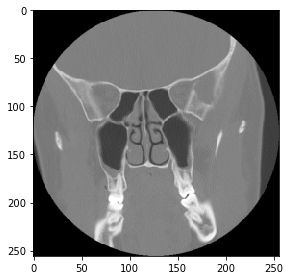

C:\Users\Maryna_Hubarenko\anaconda3\envs\u_net\envs\u-net\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


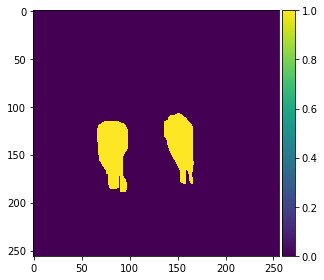

In [10]:
for i in range(0,1):
    imshow(X_train[i].astype(np.uint8))
    plt.show()
    imshow(Y_train[i].astype(np.uint8))
    plt.show()



In [19]:
def get_model(IMG_HEIGHT, IMG_WEIGHT, IMG_CHANNELS):
        input_size = (IMG_HEIGHT, IMG_WEIGHT, IMG_CHANNELS)
        inputs = Input(input_size)
        #converting value of pixel from intengers into floating-point by dividing each pixel by 225
        s = Lambda(lambda x: x / 255)(inputs)
        conv1 = Conv2D(16, (3,3), activation='elu', kernel_initializer='he_normal',padding='same')(s)
        conv1 = tf.keras.layers.Dropout(0.1)(conv1)
        conv1 = Conv2D(16, (3,3), activation='elu',kernel_initializer='he_normal',padding='same')(conv1)
        pool1 = MaxPooling2D(pool_size=(2,2))(conv1)    
        conv2 = Conv2D(32, (3,3), activation='elu',kernel_initializer='he_normal',padding='same')(pool1)
        conv2 = tf.keras.layers.Dropout(0.1)(conv2)
        conv2 = Conv2D(32, (3,3), activation='elu',kernel_initializer='he_normal',padding='same')(conv2)
        pool2 = MaxPooling2D(pool_size=(2,2))(conv2)    
        conv3 = Conv2D(64, (3,3), activation='elu',kernel_initializer='he_normal',padding='same')(pool2)
        conv3 = tf.keras.layers.Dropout(0.0)(conv3)
        conv3 = Conv2D(64, (3,3), activation='elu',kernel_initializer='he_normal',padding='same')(conv3)
        pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

        conv4 = Conv2D(128, (3,3), activation='elu',kernel_initializer='he_normal',padding='same')(pool3)
        conv4 = tf.keras.layers.Dropout(0.2)(conv4)
        conv4 = Conv2D(128, (3,3), activation='elu',kernel_initializer='he_normal',padding='same')(conv4)
        pool4 = MaxPooling2D(pool_size=(2,2))(conv4)

        conv5 = Conv2D(256, (3,3), activation='elu',kernel_initializer='he_normal',padding='same')(pool4)
        conv5 = tf.keras.layers.Dropout(0.3)(conv5)
        conv5 = Conv2D(256, (3,3), activation='elu',kernel_initializer='he_normal',padding='same')(conv5)
        
        up6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
        up6 = concatenate([up6, conv4])
        conv6 = Conv2D(128, (3,3), activation='elu',kernel_initializer='he_normal',padding='same')(up6)
        conv6 = tf.keras.layers.Dropout(0.2)(conv6)
        conv6 = Conv2D(128, (3,3), activation='elu',kernel_initializer='he_normal',padding='same')(conv6)
        
        up7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
        up7 = concatenate([up7, conv3])
        conv7 = Conv2D(64, (3,3), activation='elu',padding='same')(up7)
        conv7 = tf.keras.layers.Dropout(0.2)(conv7)
        conv7 = Conv2D(64, (3,3), activation='elu',padding='same')(conv7)
        
        up8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7)
        up8 = concatenate([up8, conv2])
        conv8 = Conv2D(32, (3,3), activation='elu',kernel_initializer='he_normal',padding='same')(up8)
        conv8 = tf.keras.layers.Dropout(0.1)(conv8)
        conv8 = Conv2D(32, (3,3), activation='elu',kernel_initializer='he_normal',padding='same')(conv8)
        
        up9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8)
        up9 = concatenate([up9, conv1])
        conv9 = Conv2D(16, (3,3), activation='elu',kernel_initializer='he_normal',padding='same')(up9)
        conv9 = tf.keras.layers.Dropout(0.1)(conv9)
        conv9 = Conv2D(16, (3,3), activation='elu',kernel_initializer='he_normal',padding='same')(conv9)

        conv10 = Conv2D(1, (1,1), activation='sigmoid')(conv9)

        model = Model(inputs=[inputs], outputs=[conv10])

        model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

        return model

In [20]:
model1 = get_model(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

In [17]:
checkpointer = ModelCheckpoint('model-unet-300.h5', verbose=1)
earlystopper = EarlyStopping(monitor='val_loss', patience=6, verbose=1)
history = model1.fit(x=X_train, 
                    y=Y_train,
                    validation_split=0.2, 
                    batch_size=4, 
                    epochs=300, 
                    callbacks=[checkpointer])

In [ ]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

In [ ]:
list_of_metrics = model.evaluate(X_test, Y_test, batch_size=2, verbose=1, sample_weight=None)
index = 0
print('\nMetrics:')
for metric in model.metrics_names:
    print(metric+ ':' , str(list_of_metrics[index]))
    index += 1

In [ ]:
model1.save("model-unet-300.h5")
for i in range(0,len(X_test)-1):
    x= X_test[i]
    x = np.expand_dims(x, axis=0)
    predict = model1.predict(x)
    predict = np.squeeze(predict)
    predict =(predict>0.5).astype(np.uint8)
    plt.figure(figsize=(12,6))
    plt.subplot(131)
    plt.imshow(predict)
    plt.subplot(132)
    imshow(Y_test[i].astype(np.uint8))
    plt.subplot(133)
    imshow(X_test[i].astype(np.uint8))
    plt.show()

In [ ]:
X_train_aug = np.zeros((len(train_img_ids) * 4, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train_aug = np.zeros((len(train_img_ids) * 4, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

for i in range(0, len(X_train)):
    X_train_aug[i * 4] = X_train[i]
    Y_train_aug[i * 4] = Y_train[i]
    X_train_aug[i * 4 + 1] = X_train[i]
    Y_train_aug[i * 4 + 1] = Y_train[i]
    X_train_aug[i * 4 + 2] = X_train[i]
    Y_train_aug[i * 4 + 2] = Y_train[i]
    X_train_aug[i * 4 + 3] = X_train[i]
    Y_train_aug[i * 4 + 3] = Y_train[i]

seq =iaa.Sequential([
    iaa.OneOf([iaa.Affine(translate_px={"x": (-10, 10), "y": (-10, 10)}), 
               iaa.Affine(rotate=(-90, 90)),
               iaa.Affine(shear=(-20, 20)),
               iaa.Crop(percent=(0, 0.15))
        ]),
    iaa.SomeOf((0,4),[
        iaa.Fliplr(1.0), # horizontally flip
        iaa.Flipud(1.0),# Vertical flip
        iaa.Add((-20,20)),
        iaa.Multiply((0.5, 1.5)),
        iaa.Sharpen(alpha=(0, 0.4), lightness=(0.5, 1.5)), # sharpen images        
        iaa.GaussianBlur(sigma=(0, 0.2)),
#         iaa.AdditiveGaussianNoise(scale=(0, 0.2*255))
    ])
], 
random_order=True # apply the augmentations in random order
)
X_train_aug, Y_train_aug = seq(images=X_train_aug, segmentation_maps=Y_train_aug)
print(X_train_aug.shape)


In [ ]:
model2 = get_model(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

In [ ]:
checkpointer = ModelCheckpoint('model-unet-aug-300.h5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=6, verbose=1)
history = model2.fit(x=X_train_aug, 
                    y=Y_train_aug,
                    validation_split=0.2, 
                    batch_size=4, 
                    epochs=300, 
                    callbacks=[checkpointer])

In [ ]:
model2.save("model-unet-aug-300.h5")
for i in range(0,len(X_test)-1):
    x= X_test[i]
    x = np.expand_dims(x, axis=0)
    predict = model1.predict(x)
    predict = np.squeeze(predict)
    predict =(predict>0.5).astype(np.uint8)
    plt.figure(figsize=(12,6))
    plt.subplot(131)
    plt.imshow(predict)
    plt.subplot(132)
    imshow(Y_test[i].astype(np.uint8))
    plt.subplot(133)
    imshow(X_test[i].astype(np.uint8))
    plt.show()

In [ ]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')